In [22]:
# Import Dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [36]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [38]:
# get column names in measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [39]:
# get column names in station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date.desc()).all()
# for measure in last_year_prcp:
#     print(measure.date, measure.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(last_year_prcp, columns=['Date', 'Precip (in)'])
last_year_prcp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
last_year_prcp_df_sorted = last_year_prcp_df.sort_values(by='Date')
last_year_prcp_df_sorted.head()

,Precip (in)
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


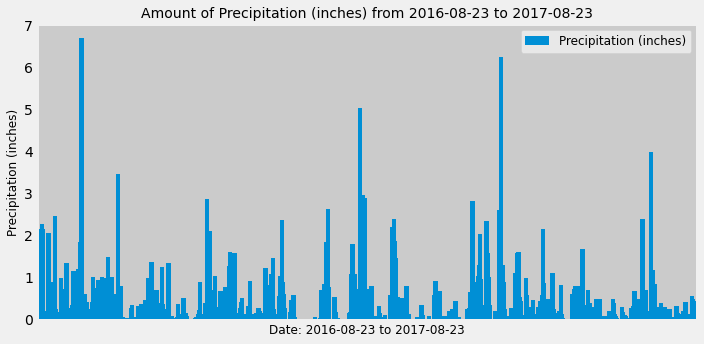

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = last_year_prcp_df_sorted.plot(kind='bar', figsize=(10,5), width=15)
ax.legend(['Precipitation (inches)'], fontsize=12)
ax.set_xlabel(f'Date: {one_year_ago} to 2017-08-23', fontsize=12)
ax.set_ylabel('Precipitation (inches)', fontsize=12)
ax.set_title(f'Amount of Precipitation (inches) from {one_year_ago} to 2017-08-23', fontsize=14)

# turn off xticklabels - stackoverflow reference
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks
    bottom=False,      # ticks along the bottom off
    top=False,         # ticks along the top off
    labelbottom=False) # labels along the bottom off

plt.tight_layout()
plt.show()

In [63]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_prcp_df_sorted.describe()

,Precip (in)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [64]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
print(f'The number of stations in the dataset is {stations}.')

The number of stations in the dataset is 9.


In [66]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count()).group_by(Measurement.station).order_by(func.count().desc()).all()
for station, actions in active_stations:
    print(station, actions)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

most_active_stats

[(54.0, 85.0, 71.66378066378067)]

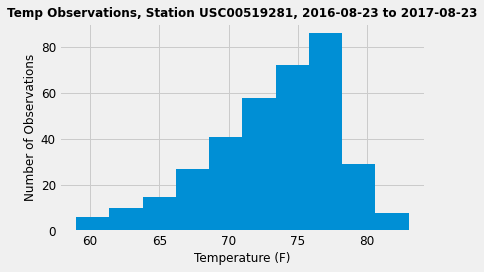

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prior_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

most_active_prior_yr = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= prior_year).all()
# most_active_prior_yr

active_station_df = pd.DataFrame(most_active_prior_yr)
active_station_df.plot.hist(legend=False, fontsize=12)
plt.xlabel('Temperature (F)', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)
plt.title(f'Temp Observations, Station USC00519281, {prior_year} to 2017-08-23', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Close session

In [90]:
# Close Session
session.close()